In [2]:
import pandas as pd
from tinygrad.tensor import Tensor
from tinygrad.nn import optim
from tinygrad.nn.state import get_parameters
from loggpt import LogGPT, GPTConfig
from matplotlib import pyplot as plt

Matplotlib is building the font cache; this may take a moment.


In [3]:

df = pd.read_csv("../dataset.csv", sep=";")
df

,TemplateID,Text
0,1,* * * * * * * * * *
1,2,/*********************************************...
2,3,STARTUP_MSG Starting DataNode
3,4,STARTUP_MSG * = *
4,4,STARTUP_MSG * = *
...,...,...
2064963,40,* * * * * INFO org.apache.hadoop.hdfs.server.d...
2064964,17,* * * * * INFO org.apache.hadoop.hdfs.server.d...
2064965,66,* * * * * INFO org.apache.hadoop.hdfs.server.d...
2064966,40,* * * * * INFO org.apache.hadoop.hdfs.server.d...


In [55]:
seq_len = 10
def create_sequences(df, window_size, target_size=1):
    """
    Create sliding window sequences (X) and target values (Y) from a DataFrame.
    
    Parameters:
    df (pd.DataFrame): Input DataFrame containing 'TemplateID' column
    window_size (int): Size of the sliding window for input sequences
    target_size (int): Size of the target sequence (default: 1)
    
    Returns:
    tuple: (X, y) where X contains input sequences and y contains target values
    """
    data = df['TemplateID'].values
    X, y = [], []
    
    # Create sequences
    for i in range(len(data) - window_size - target_size + 1):
        # Input sequence
        window = data[i:(i + window_size)]
        # Target sequence
        target = data[(i + window_size):(i + window_size + target_size)]
        
        X.append(window)
        y.append(target)
    
    return Tensor(X), Tensor(y)

batch_size = 64

data = df[:batch_size*80000]

# x, y = create_sequences(data, window_size=seq_len)


print(x)
print(y)


<Tensor <UOp METAL (1, 9) long ShapeTracker(views=(View(shape=(1, 9), strides=(0, 1), offset=0, mask=None, contiguous=True),))> on METAL with grad None>
<Tensor <UOp METAL (1, 1) long ShapeTracker(views=(View(shape=(1, 1), strides=(0, 0), offset=10, mask=None, contiguous=False),))> on METAL with grad None>


Epoch 1, Loss: 4.90934419631958
Epoch 2, Loss: 4.851656913757324
Epoch 3, Loss: 4.782214164733887
Epoch 4, Loss: 4.723125457763672
Epoch 5, Loss: 4.690863132476807
Epoch 6, Loss: 4.516685962677002
Epoch 7, Loss: 4.539649486541748
Epoch 8, Loss: 4.478248596191406
Epoch 9, Loss: 4.492267608642578
Epoch 10, Loss: 4.450549125671387
Epoch 11, Loss: 4.313704490661621
Epoch 12, Loss: 4.356058597564697
Epoch 13, Loss: 4.232590198516846
Epoch 14, Loss: 4.368903160095215
Epoch 15, Loss: 4.234124660491943
Epoch 16, Loss: 4.249415874481201
Epoch 17, Loss: 4.1834330558776855
Epoch 18, Loss: 4.100923538208008
Epoch 19, Loss: 4.108241081237793
Epoch 20, Loss: 3.996678590774536
Epoch 21, Loss: 4.149546146392822
Epoch 22, Loss: 4.164669513702393
Epoch 23, Loss: 3.964677572250366
Epoch 24, Loss: 4.097247123718262
Epoch 25, Loss: 3.879438638687134
Epoch 26, Loss: 3.9628491401672363
Epoch 27, Loss: 3.868401050567627
Epoch 28, Loss: 3.9949429035186768
Epoch 29, Loss: 4.067773342132568
Epoch 30, Loss: 4.118

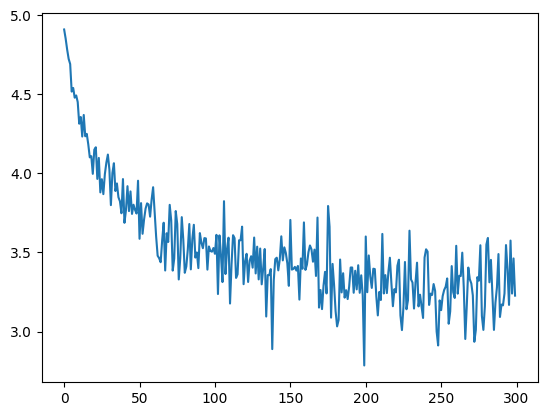

In [61]:

vocab_size = df['TemplateID'].nunique()
num_layers = 6
num_heads = 4
embed_dim = 128
learning_rate = 1e-3
epochs = 300

model = LogGPT(GPTConfig(
	block_size=seq_len,
	vocab_size=vocab_size,
	n_layer=num_layers,
	n_head=num_heads,
	embed_dim=embed_dim
))

optimizer = optim.SGD(get_parameters(model), lr=learning_rate)
losses = []

with Tensor.train():
	for epoch in range(epochs):
		# x = x[:batch_size]
		# y = y[:batch_size]

		rand_seq = data['TemplateID'].sample((seq_len + 1) * batch_size).values
		t = Tensor(rand_seq).reshape(batch_size, seq_len + 1)
		# print(t)
		x = t[:batch_size, :-1]
		y = t[:batch_size, -1]
		# print(x)
		# print(y)

		logits, loss = model(x, y)

		optimizer.zero_grad()
		loss.backward()
		optimizer.step()

		print(f"Epoch {epoch + 1}, Loss: {loss.numpy()}")
		losses.append(loss.numpy())

		# if epoch % 10 == 0:
		# 	plt.plot(losses)
		# 	plt.show()
		# 	print("Predicted:", logits.argmax(-1).numpy())
		# 	print("Actual:", y.numpy())
		# 	print("Loss:", loss.numpy())

plt.plot(losses)

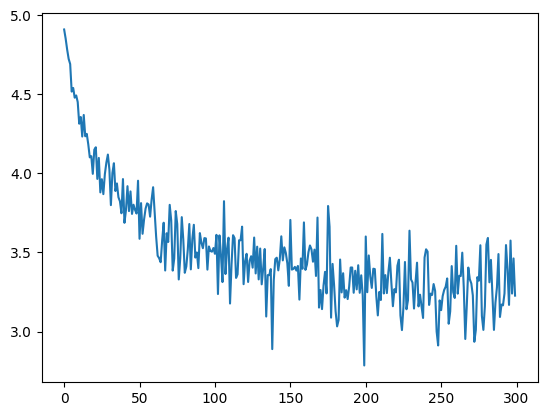

In [62]:


plt.plot(losses)

In [67]:

# pick dandom start from df
rand_seq = df['TemplateID'].sample(seq_len).values
rand_seq = Tensor(rand_seq).reshape(1, -1)

# print(logits.argmax(-1)[0][0].numpy())

def get_template_text(logits, df):
    return df.where(df['TemplateID'] == logits.argmax(-1)[0][0].numpy()).dropna()["Text"].values[0]
    

for i in range(20):
    logits, _ = model(rand_seq)
    print(get_template_text(logits, df))
    rand_seq = Tensor([logits.argmax(-1)[0][0].numpy()] + rand_seq.numpy().tolist()[0][:-1]).reshape(1, -1)
# logits, _ = model(rand_seq)
# print(get_template_text(logits, df))

* * * * * INFO org.apache.hadoop.hdfs.server.datanode.DataNode.clienttrace  src  * *  dest  /10.10.34.29 *  bytes  *  op  HDFS_WRITE  cliID  *  offset  *  srvID  cfd79aa1-45f8-4e65-ad3a-96b42cd4bad2  blockid  BP-108841162-10.10.34.11-1440074360971 *  duration  *
* * * * * INFO org.apache.hadoop.hdfs.server.datanode.DataNode.clienttrace  src  * *  dest  /10.10.34.29 *  bytes  *  op  HDFS_WRITE  cliID  *  offset  *  srvID  cfd79aa1-45f8-4e65-ad3a-96b42cd4bad2  blockid  BP-108841162-10.10.34.11-1440074360971 *  duration  *
* * * * * INFO org.apache.hadoop.hdfs.server.datanode.DataNode.clienttrace  src  * *  dest  /10.10.34.29 *  bytes  *  op  HDFS_WRITE  cliID  *  offset  *  srvID  cfd79aa1-45f8-4e65-ad3a-96b42cd4bad2  blockid  BP-108841162-10.10.34.11-1440074360971 *  duration  *
* * * * * INFO org.apache.hadoop.hdfs.server.datanode.DataNode.clienttrace  src  * *  dest  /10.10.34.29 *  bytes  *  op  HDFS_WRITE  cliID  *  offset  *  srvID  cfd79aa1-45f8-4e65-ad3a-96b42cd4bad2  blockid  BP

In [66]:

# Calculate perplexity

def perplexity(logits, y):
    """
    Calculate perplexity of a model given logits and target values.
    
    Parameters:
    logits (Tensor): Logits from the model
    y (Tensor): Target values
    
    Returns:
    float: Perplexity of the model
    """
    return 2**(-logits[y].mean())

perplexities = []

# a = Tensor([1, 2, 3])
# b = Tensor([1, 2, 3])
# c = a + b

for i in range(20):
    rand_seq = df['TemplateID'].sample(seq_len + 1).values
    t = Tensor(rand_seq)
    x = t[:-2].reshape(1, -1)
    y = t[-1].reshape(1, -1)
    print("y", y.numpy())
    print("predicted", logits.argmax(-1).numpy())

    # logits, loss = model(x, y)
    # print("loss", loss.numpy())
    # print("perplexity", loss.exp().numpy())

    
    # # print("logits", logits.numpy())
    # perp = perplexity(logits, y).numpy()
    # perplexities.append(perp)
    # print(f"Perplexity: {perp}")

#print(f"Perplexity: {sum(perplexities) / len(perplexities)}")

y [[63]]
predicted [63]
y [[63]]
predicted [63]
y [[63]]
predicted [63]
y [[104]]
predicted [63]
y [[63]]
predicted [63]
y [[49]]
predicted [63]
y [[54]]
predicted [63]
y [[63]]
predicted [63]
y [[63]]
predicted [63]
y [[64]]
predicted [63]
y [[63]]
predicted [63]
y [[63]]
predicted [63]
y [[63]]
predicted [63]
y [[61]]
predicted [63]
y [[64]]
predicted [63]
y [[67]]
predicted [63]
y [[109]]
predicted [63]
y [[46]]
predicted [63]
y [[67]]
predicted [63]
y [[61]]
predicted [63]
